In [1]:
import dgl
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pickle
import matplotlib.pyplot as plt
import pandas as pd
from KGCN import Model, loss_fn

Using backend: pytorch


In [2]:
def process_graph(graph: dgl.heterograph):
    number_of_users = graph.num_nodes('user')
    number_of_repos = graph.num_nodes('repo')
    ground_truth = torch.zeros((number_of_users, number_of_repos), dtype=torch.int8)
    user_repo = torch.zeros((number_of_users, number_of_repos), dtype=torch.int8)
    for etype in graph.canonical_etypes:
        # ignore the reverse relation
        if etype[0] != 'user' and etype[1] != 'repo':
            continue
        # sample 40% for testing
        number_of_edges = graph.number_of_edges(etype=etype)
        train_number = round(number_of_edges * 0.6)
        test_number = round(number_of_edges * 0.4)
        sample_indexes = np.array([0] * train_number + [1] * test_number)
        np.random.shuffle(sample_indexes)

        train_mask = sample_indexes==0
        test_mask = sample_indexes==1

        edges = graph.edges(etype=etype)
        edge_ids = graph.edge_ids(edges[0], edges[1], etype=etype)

        graph.remove_edges(edge_ids[test_mask], etype=etype)

        ground_truth[edges[0][test_mask], edges[1][test_mask]] = 1
        user_repo[edges[0], edges[1]] = 1
    
    repos_per_user = torch.sum(user_repo, axis=1)

    return graph, ground_truth, repos_per_user.numpy()

In [8]:
training_results = []

In [9]:
EPOCH = 100
TOP_K = 10
neg_sample_size = 5

g, l = dgl.load_graphs('./data/sub_kowledge_graph.bin')
train_graph = g[0]
valid_graph = g[1]
test_graph = g[2]

model = Model(train_graph, 150, 261, 50)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

sampler = dgl.dataloading.MultiLayerFullNeighborSampler(2)
edges_fork = train_graph.edges(etype=('user', 'fork', 'repo'))
edges_own = train_graph.edges(etype=('user', 'own', 'repo'))
edges_star = train_graph.edges(etype=('user', 'star', 'repo'))
edges_watch = train_graph.edges(etype=('user', 'watch', 'repo'))
train_eid = {('user', 'fork', 'repo'): train_graph.edge_ids(edges_fork[0], edges_fork[1], etype=('user', 'fork', 'repo')),
    ('user', 'own', 'repo'): train_graph.edge_ids(edges_own[0], edges_own[1], etype=('user', 'own', 'repo')),
    ('user', 'star', 'repo'): train_graph.edge_ids(edges_star[0], edges_star[1], etype=('user', 'star', 'repo')),
    ('user', 'watch', 'repo'): train_graph.edge_ids(edges_watch[0], edges_watch[1], etype=('user', 'watch', 'repo'))}
dataloader = dgl.dataloading.EdgeDataLoader(
train_graph, train_eid, sampler,
exclude='reverse_types',
reverse_etypes={'watch': 'watched-by', 'watched-by': 'watch',
                'star': 'starred-by', 'starred-by': 'star',
                'fork': 'forked-by', 'forked-by': 'fork',
                'own': 'owned-by', 'owned-by': 'own'},
negative_sampler=dgl.dataloading.negative_sampler.Uniform(neg_sample_size),
batch_size=1024, shuffle=True, drop_last=False)

processed_valid_graph, ground_truth_valid_data, repos_per_user_valid = process_graph(valid_graph)
processed_test_graph, ground_truth_test_data, repos_per_user_test = process_graph(test_graph)

for epoch in range(EPOCH):
    training_loops = 0
    total_loss = 0
    for input_nodes, pos_g, neg_g, blocks in dataloader:
        user_feat = blocks[0].ndata['graph_data']['user']
        repo_feat = blocks[0].ndata['graph_data']['repo']
        model.train()
        pos_score, neg_score = model(blocks, pos_g, neg_g, user_feat, repo_feat)
        loss = loss_fn(pos_score, neg_score, neg_sample_size)

        total_loss += loss.item()
        training_loops += 1

        # Backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    train_avg_loss = total_loss / training_loops

    if epoch % 5 == 0:
        # valid top k recommendation
        valid_mean_hit_rate = 0
        valid_group_0_5_hit_rate = 0
        valid_group_5_10_hit_rate = 0
        valid_group_10_15_hit_rate = 0
        valid_group_15_over_hit_rate = 0
        model.eval()
        with torch.no_grad():
            hit_rates = np.zeros(valid_graph.num_nodes('user'))
            group_0_5 = []
            group_5_10 = []
            group_10_15 = []
            group_15_over = []

            h_user = model.user_embedding(processed_valid_graph.ndata['graph_data']['user'])
            h_repo = model.repo_embedding(processed_valid_graph.ndata['graph_data']['repo'])

            h_dict = {
                'user': h_user,
                'repo': h_repo
            }

            h = model.hidden(processed_valid_graph, h_dict)
            out = model.out(processed_valid_graph, h)

            user_embedding = out['user']
            repo_embedding = out['repo']

            user_emb_normalized = F.normalize(user_embedding)
            repo_emb_normalized = F.normalize(repo_embedding)

            user_repo_rating = user_emb_normalized @ repo_emb_normalized.T
            for i, rating in enumerate(user_repo_rating):
                recommendation = rating.detach().numpy()
                recommendation = recommendation.argsort()[-TOP_K:]
                ground_truth = np.where(ground_truth_valid_data[i]>0)[0]

                recommendation_set = set(recommendation)
                ground_truth_set = set(ground_truth)

                intersections = recommendation_set.intersection(ground_truth_set)
                number_of_intersections = len(intersections)
                number_of_ground_truth = len(ground_truth_set)
                hit_rate = 0 if number_of_ground_truth == 0 else number_of_intersections / min(number_of_ground_truth, TOP_K)
                hit_rates[i] = min(hit_rate, 1)

                # grouping
                if repos_per_user_valid[i] < 5:
                    group_0_5.append(i)
                elif repos_per_user_valid[i] < 10:
                    group_5_10.append(i)
                elif repos_per_user_valid[i] < 15:
                    group_10_15.append(i)
                else:
                    group_15_over.append(i)

            valid_mean_hit_rate = np.mean(hit_rates)
            valid_group_0_5_hit_rate = np.mean(hit_rates[group_0_5])
            valid_group_5_10_hit_rate = np.mean(hit_rates[group_5_10])
            valid_group_10_15_hit_rate = np.mean(hit_rates[group_10_15])
            valid_group_15_over_hit_rate = np.mean(hit_rates[group_15_over])

        # test top k recommendation
        test_mean_hit_rate = 0
        test_group_0_5_hit_rate = 0
        test_group_5_10_hit_rate = 0
        test_group_10_15_hit_rate = 0
        test_group_15_over_hit_rate = 0
        model.eval()
        with torch.no_grad():
            hit_rates = np.zeros(test_graph.num_nodes('user'))
            group_0_5 = []
            group_5_10 = []
            group_10_15 = []
            group_15_over = []

            h_user = model.user_embedding(processed_test_graph.ndata['graph_data']['user'])
            h_repo = model.repo_embedding(processed_test_graph.ndata['graph_data']['repo'])

            h_dict = {
                'user': h_user,
                'repo': h_repo
            }

            h = model.hidden(processed_test_graph, h_dict)
            out = model.out(processed_test_graph, h)

            user_embedding = out['user']
            repo_embedding = out['repo']

            user_emb_normalized = F.normalize(user_embedding)
            repo_emb_normalized = F.normalize(repo_embedding)

            user_repo_rating = user_emb_normalized @ repo_emb_normalized.T
            for i, rating in enumerate(user_repo_rating):
                recommendation = rating.detach().numpy()
                recommendation = recommendation.argsort()[-TOP_K:]
                ground_truth = np.where(ground_truth_test_data[i]>0)[0]

                recommendation_set = set(recommendation)
                ground_truth_set = set(ground_truth)

                intersections = recommendation_set.intersection(ground_truth_set)
                hit_rate = 0 if len(ground_truth_set) == 0 else len(intersections) / min(len(ground_truth_set), TOP_K)
                hit_rates[i] = min(hit_rate, 1)

                # grouping
                if repos_per_user_test[i] < 5:
                    group_0_5.append(i)
                elif repos_per_user_test[i] < 10:
                    group_5_10.append(i)
                elif repos_per_user_test[i] < 15:
                    group_10_15.append(i)
                else:
                    group_15_over.append(i)

            test_mean_hit_rate = np.mean(hit_rates)
            test_group_0_5_hit_rate = np.mean(hit_rates[group_0_5])
            test_group_5_10_hit_rate = np.mean(hit_rates[group_5_10])
            test_group_10_15_hit_rate = np.mean(hit_rates[group_10_15])
            test_group_15_over_hit_rate = np.mean(hit_rates[group_15_over])

        print('In epoch {}, loss: {:.3f}, valid hit rate: {:.3f}, test hit rate: {:.3f}'.format(
            epoch, train_avg_loss, valid_mean_hit_rate, test_mean_hit_rate))
        print('Valid - Group 0 to 5: {:.3f}, Group 5 to 10: {:.3f}, Group 10 to 15: {:.3f}, Group 15 to 20: {:.3f}'.format(
            valid_group_0_5_hit_rate, valid_group_5_10_hit_rate, valid_group_10_15_hit_rate, valid_group_15_over_hit_rate
        ))
        print('Test - Group 0 to 5: {:.3f}, Group 5 to 10: {:.3f}, Group 10 to 15: {:.3f}, Group 15 to 20: {:.3f}'.format(
            test_group_0_5_hit_rate, test_group_5_10_hit_rate, test_group_10_15_hit_rate, test_group_15_over_hit_rate
        ))
        print()
        training_results.append([epoch, 
                                 train_avg_loss, 
                                 valid_mean_hit_rate, 
                                 test_mean_hit_rate, 
                                 valid_group_0_5_hit_rate, 
                                 valid_group_5_10_hit_rate, 
                                 valid_group_10_15_hit_rate, 
                                 valid_group_15_over_hit_rate, 
                                 test_group_0_5_hit_rate, 
                                 test_group_5_10_hit_rate, 
                                 test_group_10_15_hit_rate, 
                                 test_group_15_over_hit_rate])

In epoch 0, loss: 0.138, valid hit rate: 0.011, test hit rate: 0.020
Valid - Group 0 to 5: 0.012, Group 5 to 10: 0.005, Group 10 to 15: 0.002, Group 15 to 20: 0.004
Test - Group 0 to 5: 0.021, Group 5 to 10: 0.000, Group 10 to 15: 0.004, Group 15 to 20: 0.005

In epoch 5, loss: 0.062, valid hit rate: 0.019, test hit rate: 0.017
Valid - Group 0 to 5: 0.021, Group 5 to 10: 0.000, Group 10 to 15: 0.003, Group 15 to 20: 0.000
Test - Group 0 to 5: 0.018, Group 5 to 10: 0.000, Group 10 to 15: 0.000, Group 15 to 20: 0.000

In epoch 10, loss: 0.059, valid hit rate: 0.013, test hit rate: 0.016
Valid - Group 0 to 5: 0.014, Group 5 to 10: 0.004, Group 10 to 15: 0.000, Group 15 to 20: 0.005
Test - Group 0 to 5: 0.017, Group 5 to 10: 0.008, Group 10 to 15: 0.004, Group 15 to 20: 0.000

In epoch 15, loss: 0.058, valid hit rate: 0.016, test hit rate: 0.023
Valid - Group 0 to 5: 0.017, Group 5 to 10: 0.004, Group 10 to 15: 0.000, Group 15 to 20: 0.000
Test - Group 0 to 5: 0.026, Group 5 to 10: 0.000, 

In [18]:
data = pd.DataFrame(training_results, 
                    columns=['epoch', 
                             'loss', 
                             'valid hit rate', 
                             'test hit rate', 
                             'valid group 0 to 5', 
                             'valid group 5 to 10', 
                             'valid group 10 to 15', 
                             'valid group 15 over', 
                             'test group 0 to 5', 
                             'test group 5 to 10', 
                             'test group 10 to 15', 
                             'test group 15 over'])

In [19]:
data

,epoch,loss,valid hit rate,test hit rate,valid group 0 to 5,valid group 5 to 10,valid group 10 to 15,valid group 15 over,test group 0 to 5,test group 5 to 10,test group 10 to 15,test group 15 over
0,0,0.138493,0.011268,0.019737,0.011924,0.005144,0.002381,0.004348,0.021463,0.000000,0.003509,0.004630
1,5,0.062025,0.019352,0.016599,0.020994,0.000000,0.003333,0.000000,0.018197,0.000000,0.000000,0.000000
2,10,0.059348,0.013143,0.016003,0.014088,0.004115,0.000000,0.004831,0.016984,0.008242,0.004386,0.000000
3,15,0.057839,0.016126,0.023493,0.017403,0.004115,0.000000,0.000000,0.025756,0.000000,0.000000,0.000000
4,20,0.055128,0.024364,0.028402,0.025829,0.010288,0.006667,0.004831,0.030702,0.007326,0.001949,0.000000
5,25,0.050938,0.027361,0.030984,0.029328,0.003086,0.009444,0.004831,0.033781,0.003663,0.000000,0.000000
6,30,0.036549,0.045736,0.043389,0.049632,0.003086,0.003333,0.000000,0.047219,0.000000,0.003509,0.017593
7,35,0.031740,0.039226,0.041826,0.041805,0.007202,0.011435,0.021601,0.045353,0.003663,0.007895,0.004630
8,40,0.029562,0.049504,0.045615,0.053131,0.007202,0.009583,0.017253,0.049179,0.007326,0.012350,0.004630
9,45,0.028814,0.045802,0.039973,0.049540,0.000000,0.004167,0.021601,0.043113,0.003663,0.008967,0.017593


Text(0.5, 1.0, 'Loss per epoch')

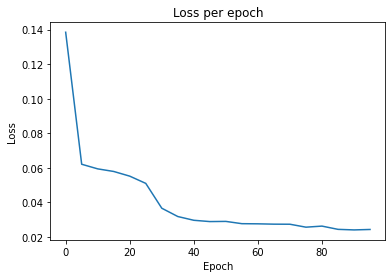

In [29]:
plt.plot(data['epoch'], data['loss'], label='loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss per epoch')

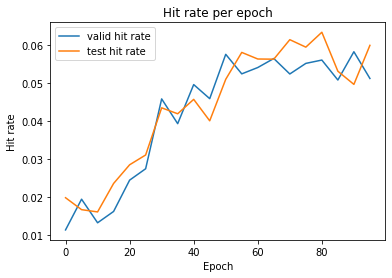

In [30]:
plt.plot(data['epoch'], data['valid hit rate'], label='valid hit rate')
plt.plot(data['epoch'], data['test hit rate'], label='test hit rate')
plt.xlabel('Epoch')
plt.ylabel('Hit rate')
plt.title('Hit rate per epoch')
plt.legend()

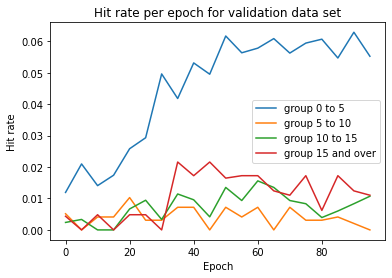

In [31]:
plt.plot(data['epoch'], data['valid group 0 to 5'], label='group 0 to 5')
plt.plot(data['epoch'], data['valid group 5 to 10'], label='group 5 to 10')
plt.plot(data['epoch'], data['valid group 10 to 15'], label='group 10 to 15')
plt.plot(data['epoch'], data['valid group 15 over'], label='group 15 and over')
plt.xlabel('Epoch')
plt.ylabel('Hit rate')
plt.title('Hit rate per epoch for validation data set')
plt.legend()

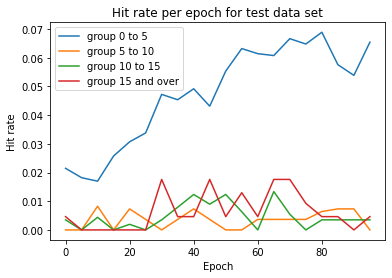

In [32]:
plt.plot(data['epoch'], data['test group 0 to 5'], label='group 0 to 5')
plt.plot(data['epoch'], data['test group 5 to 10'], label='group 5 to 10')
plt.plot(data['epoch'], data['test group 10 to 15'], label='group 10 to 15')
plt.plot(data['epoch'], data['test group 15 over'], label='group 15 and over')
plt.xlabel('Epoch')
plt.ylabel('Hit rate')
plt.title('Hit rate per epoch for test data set')
plt.legend()